In [1]:
#LIBRARY IMPORT
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
print(tf.__version__)

2.5.0


In [2]:
#CONSTANT DEFINE
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 200

In [3]:
#IMPORT DATASET WITH LABELS FROM DIRECTORY
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset_pv",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,    
)

Found 9140 files belonging to 10 classes.


In [4]:
#PRINT LKABELS NAME
class_names = dataset.class_names
class_names

['Apple',
 'Blueberry',
 'Corn',
 'Grape',
 'Peach',
 'Pepper',
 'Potato',
 'Raspberry',
 'Strawberry',
 'Tomato']

In [5]:
#PRINT BATCHS NUMBER
len(dataset)

286

In [6]:
#PRINT IMAGES NUMBER
32*len(dataset)

9152

In [7]:
#PRINT FIRST BATCH SHAPE AND LABELS
for image_batch, label_batch in dataset.take(1):
    print("Print first batch shape:")
    print(image_batch.shape)
    
    print("print first batch labels:")
    print(label_batch.numpy())

Print first batch shape:
(32, 256, 256, 3)
print first batch labels:
[0 2 9 9 9 0 1 9 9 5 1 6 9 9 9 4 6 9 6 5 2 9 1 9 1 1 1 2 9 5 5 9]


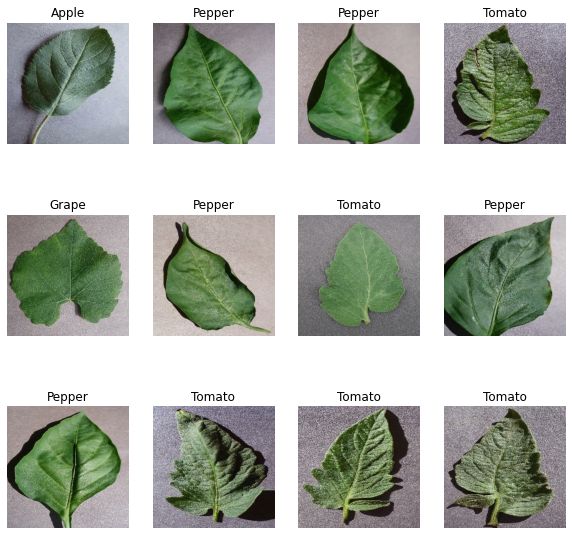

In [8]:
#SHOW FIRST BATCH IMAGES WITH LABELS
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")


In [9]:
#SPLIT DATABASE IN TRAINING, VALIDATION AND TEST(80%, 10%, 10%)
#TRAIN
train_size = 0.8
len(dataset)*train_size
train_ds=dataset.take(143)
len(train_ds)

143

In [10]:
#VALIDATION + TEST
test_ds=dataset.skip(143)
val_size= 0.1
len(dataset)*val_size

28.6

In [11]:
#VALIDATION
val_ds = test_ds.take(29)
len(val_ds)

29

In [12]:
#TEST
test_ds=test_ds.skip(29)
len(test_ds)

114

In [13]:
#FUNCTION THAT RETURN DATASET SPLITTED IN TRAIN, VALIDATION AND TEST
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
        
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
#SPLIT DATASET
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [15]:
#CECK TRAIN DATASET LENGHT
len(train_ds)

228

In [16]:
#CECK VALIDATION DATASET LENGHT
len(val_ds)

28

In [17]:
#CECK TEST DATASET LENGHT
len(test_ds)

30

In [18]:
#FETCH SOME FUNCTIONS TO USE THEM IN FOLLOW EPOCHS
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
#PREPROCESSING: CREATE SOME LAYERS TO PREPROCESSING IMAGES
#(we do this to make more robust the prediction with totation, zoom, contrast...)

In [20]:
#SCALE RGB TENSOR TO 0-1 VALUES 
resize_and_rescale= tf.keras.Sequential([layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
                                        layers.experimental.preprocessing.Rescaling(1.0/255)])


In [21]:
#FLIP AND ROTATE RANDOMLY IMAGES  
data_augmentation=tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                       layers.experimental.preprocessing.RandomRotation(0.2)])

In [22]:
#APPLY DATA AUGMENTATION TO TRAIN DATASET
train_ds =train_ds.map(lambda x,y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
#CNN ARCHITECTURE CREATE 
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)
model = models.Sequential([
    #Applies preprocessing layers
    resize_and_rescale,
    
    #Applies CNN layers
    layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape), #Convolutional layer
    layers.MaxPooling2D((2,2)), #Pooling layer  
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),  #Convolutional layer
    layers.MaxPooling2D((2,2)), #Pooling layer 
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),  #Convolutional layer
    layers.MaxPooling2D((2,2)), #Pooling layer
    layers.Conv2D(64,(3,3), activation='relu'),  #Convolutional layer
    layers.MaxPooling2D((2,2)), #Pooling layer
    layers.Conv2D(64,(3,3), activation='relu'),  #Convolutional layer
    layers.MaxPooling2D((2,2)), #Pooling layer
    layers.Conv2D(64,(3,3), activation='relu'),  #Convolutional layer
    layers.MaxPooling2D((2,2)), #Pooling layer
    
    #Flat neurons
    layers.Flatten(),    
    #Applies the rectified linear unit activation functio
    layers.Dense(64, activation="relu"),    
    #Converts a vector of values to a probability distribution
    layers.Dense(n_classes, activation='softmax')
])


In [24]:
#BUILD CNN MODEL
model.build(input_shape=input_shape)

In [25]:
#PRINT MODEL SUMMARY INFO 
#(Total params = number of CNN weights)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

In [26]:
#CNN ARCHITECTURE COMPILE WITH A LOOS FUNCTION AND AN OPTIMIZER
#(Optimizer= Adam; Loos function= SparseCategoricalCrossentropy)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
#CNN RUN WITH TRAIN DATASET
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds    
)

Epoch 1/200
228/228 [==============================] - 556s 2s/step - loss: 1.4222 - accuracy: 0.4761 - val_loss: 0.8679 - val_accuracy: 0.7042
Epoch 2/200
228/228 [==============================] - 534s 2s/step - loss: 0.7069 - accuracy: 0.7477 - val_loss: 0.6972 - val_accuracy: 0.7623
Epoch 3/200
228/228 [==============================] - 544s 2s/step - loss: 0.5140 - accuracy: 0.8291 - val_loss: 0.3962 - val_accuracy: 0.8739
Epoch 4/200
228/228 [==============================] - 546s 2s/step - loss: 0.4148 - accuracy: 0.8629 - val_loss: 0.5154 - val_accuracy: 0.8237
Epoch 5/200
228/228 [==============================] - 551s 2s/step - loss: 0.3679 - accuracy: 0.8742 - val_loss: 0.3621 - val_accuracy: 0.8783
Epoch 6/200
228/228 [==============================] - 558s 2s/step - loss: 0.2860 - accuracy: 0.9043 - val_loss: 0.4968 - val_accuracy: 0.8393
Epoch 7/200
228/228 [==============================] - 558s 2s/step - loss: 0.2540 - accuracy: 0.9160 - val_loss: 0.3781 - val_accuracy:

228/228 [==============================] - 547s 2s/step - loss: 0.0538 - accuracy: 0.9820 - val_loss: 0.1487 - val_accuracy: 0.9554
Epoch 58/200
228/228 [==============================] - 547s 2s/step - loss: 0.0298 - accuracy: 0.9894 - val_loss: 0.0211 - val_accuracy: 0.9911
Epoch 59/200
228/228 [==============================] - 547s 2s/step - loss: 0.0484 - accuracy: 0.9831 - val_loss: 0.0364 - val_accuracy: 0.9888
Epoch 60/200
228/228 [==============================] - 546s 2s/step - loss: 0.0524 - accuracy: 0.9820 - val_loss: 0.0333 - val_accuracy: 0.9877
Epoch 61/200
228/228 [==============================] - 545s 2s/step - loss: 0.0331 - accuracy: 0.9885 - val_loss: 0.0349 - val_accuracy: 0.9877
Epoch 62/200
228/228 [==============================] - 542s 2s/step - loss: 0.0426 - accuracy: 0.9854 - val_loss: 0.0443 - val_accuracy: 0.9855
Epoch 63/200
228/228 [==============================] - 543s 2s/step - loss: 0.0353 - accuracy: 0.9887 - val_loss: 0.0616 - val_accuracy: 0.974

228/228 [==============================] - 529s 2s/step - loss: 0.0426 - accuracy: 0.9871 - val_loss: 0.0227 - val_accuracy: 0.9877
Epoch 114/200
228/228 [==============================] - 523s 2s/step - loss: 0.0394 - accuracy: 0.9864 - val_loss: 0.0274 - val_accuracy: 0.9911
Epoch 115/200
228/228 [==============================] - 534s 2s/step - loss: 0.0172 - accuracy: 0.9949 - val_loss: 0.0690 - val_accuracy: 0.9743
Epoch 116/200
228/228 [==============================] - 538s 2s/step - loss: 0.0231 - accuracy: 0.9924 - val_loss: 0.0203 - val_accuracy: 0.9944
Epoch 117/200
228/228 [==============================] - 531s 2s/step - loss: 0.0229 - accuracy: 0.9923 - val_loss: 0.1281 - val_accuracy: 0.9565
Epoch 118/200
228/228 [==============================] - 532s 2s/step - loss: 0.0300 - accuracy: 0.9907 - val_loss: 0.0285 - val_accuracy: 0.9922
Epoch 119/200
228/228 [==============================] - 533s 2s/step - loss: 0.0261 - accuracy: 0.9914 - val_loss: 0.0334 - val_accuracy:

228/228 [==============================] - 524s 2s/step - loss: 0.0109 - accuracy: 0.9963 - val_loss: 0.0105 - val_accuracy: 0.9955
Epoch 170/200
228/228 [==============================] - 522s 2s/step - loss: 0.0198 - accuracy: 0.9937 - val_loss: 0.0109 - val_accuracy: 0.9978
Epoch 171/200
228/228 [==============================] - 521s 2s/step - loss: 0.0175 - accuracy: 0.9949 - val_loss: 0.0724 - val_accuracy: 0.9821
Epoch 172/200
228/228 [==============================] - 521s 2s/step - loss: 0.0591 - accuracy: 0.9848 - val_loss: 0.0162 - val_accuracy: 0.9955
Epoch 173/200
228/228 [==============================] - 522s 2s/step - loss: 0.0167 - accuracy: 0.9948 - val_loss: 0.0454 - val_accuracy: 0.9855
Epoch 174/200
228/228 [==============================] - 522s 2s/step - loss: 0.0095 - accuracy: 0.9973 - val_loss: 0.0351 - val_accuracy: 0.9911
Epoch 175/200
228/228 [==============================] - 520s 2s/step - loss: 0.0182 - accuracy: 0.9953 - val_loss: 0.1479 - val_accuracy:

In [28]:
#EVALUATE TRAINED CNN WITH TEST DATASET 
#[loss, accuracy]
scores = model.evaluate(test_ds)
scores

30/30 [==============================] - 43s 581ms/step - loss: 0.0080 - accuracy: 0.9969


[0.007953745312988758, 0.996874988079071]

In [29]:
#PRINT PARAMS OF FIT
history.params

{'verbose': 1, 'epochs': 200, 'steps': 228}

In [30]:
#PRINT PARAMS CALUCULATE DURING FIT
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
#PRINT ALL EPHOCS ACCURACY
history.history['accuracy']

[0.47611203789711,
 0.7476661205291748,
 0.829077422618866,
 0.8628500699996948,
 0.8742449283599854,
 0.9043108224868774,
 0.9159802198410034,
 0.9281988143920898,
 0.9260022044181824,
 0.9416529536247253,
 0.9364359974861145,
 0.9449478387832642,
 0.9531850814819336,
 0.9537342190742493,
 0.951812207698822,
 0.9537342190742493,
 0.9589511156082153,
 0.9588138461112976,
 0.9596375823020935,
 0.9711697101593018,
 0.9662273526191711,
 0.9681493639945984,
 0.9662273526191711,
 0.9710323810577393,
 0.9676002264022827,
 0.9732289910316467,
 0.9743272662162781,
 0.975151002407074,
 0.969110369682312,
 0.974739134311676,
 0.9746018648147583,
 0.9667764902114868,
 0.9817407727241516,
 0.9792696237564087,
 0.9748764634132385,
 0.9766611456871033,
 0.9776222109794617,
 0.9798187613487244,
 0.9825645089149475,
 0.9861339926719666,
 0.9783086180686951,
 0.984761118888855,
 0.9761120080947876,
 0.9805052280426025,
 0.9861339926719666,
 0.9818781018257141,
 0.9816035032272339,
 0.9824272394180298,


In [32]:
#TAKE ALL DATA OF THE FIT OPRATIONS
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']

loss = history.history['loss']
val_loss= history.history['val_loss']


Text(0.5, 1.0, 'Training and Validation Loss')

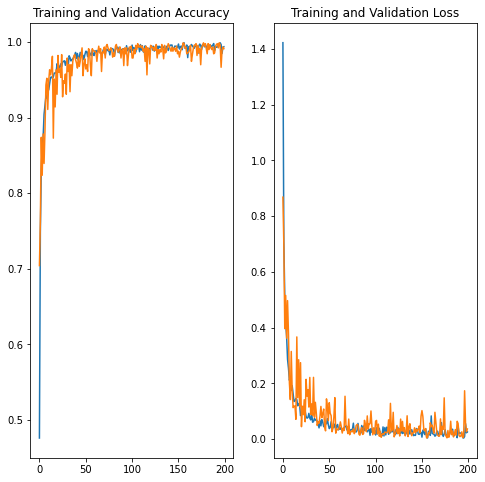

In [33]:
#PLOT KEY VALUES OF FIT
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
#plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
#plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

FIRT IMAGE TO PREDICT
first image's actual label: Blueberry
first image's predicted label: Blueberry


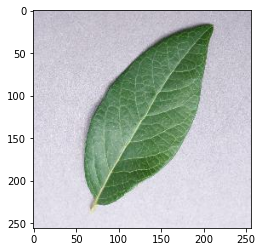

In [34]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image= images_batch[0].numpy().astype('uint8') #tensor RGB
    first_label= labels_batch[0].numpy()
    
    print("FIRT IMAGE TO PREDICT")
    plt.imshow(first_image)
    print("first image's actual label:", class_names[first_label])
    batch_prediction=model.predict(images_batch)
    print("first image's predicted label:",class_names[np.argmax(batch_prediction[0])])

In [35]:
#CREAMO UNA FUNZIONE COMPATTA PER PREDIRRE COME FATTO SOPRA
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

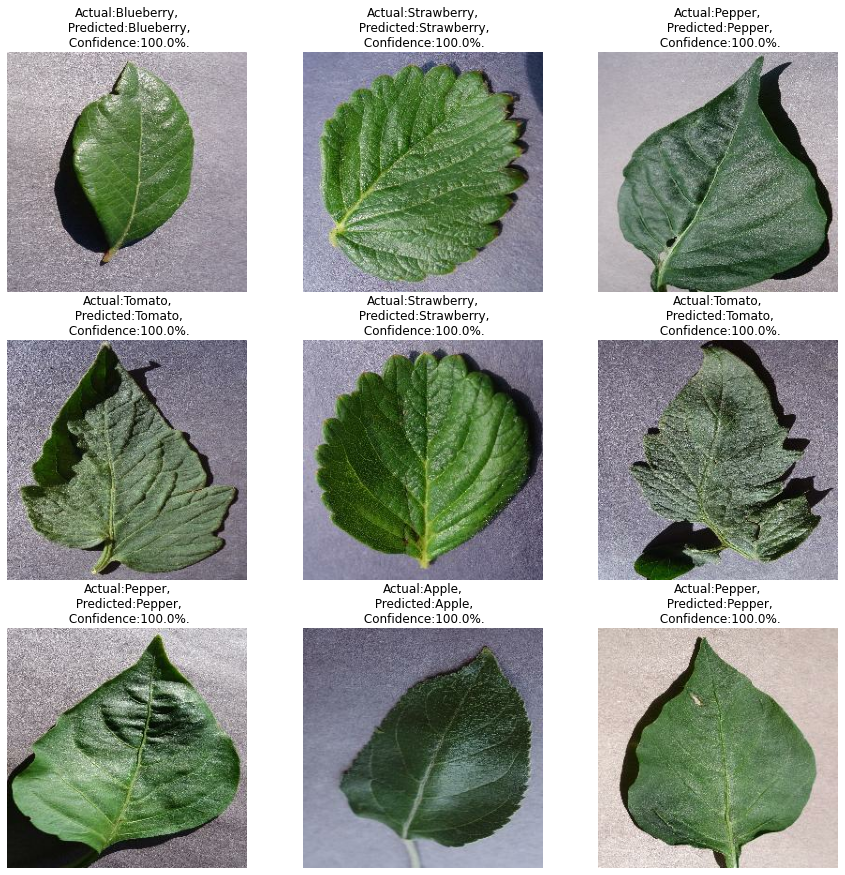

In [36]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax= plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence= predict(model, images[i].numpy)
        actual_class=class_names[labels[i]]
        
        plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class},\n Confidence:{confidence}%.")
        plt.axis("off")
        

In [37]:
#SAVE
import os
model_version=max([int(i) for i in os.listdir("./models")+[0]])+1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/1\assets


In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import numpy as np

In [39]:
model = keras.models.load_model(f"./models/{model_version}")

In [40]:
scores = model.evaluate(test_ds)

30/30 [==============================] - 17s 570ms/step - loss: 0.0080 - accuracy: 0.9969


In [41]:
TF_LITE_MODEL_FILE_NAME="tf_lite_model.tflite"

In [42]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model=tf_lite_converter.convert()

INFO:tensorflow:Assets written to: C:\Users\GABRIE~1\AppData\Local\Temp\tmprtm4crmg\assets


In [43]:
tflite_model_name=TF_LITE_MODEL_FILE_NAME
open(tflite_model_name,"wb").write(tflite_model)

743740

In [44]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details= interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])

print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 256 256   3]
Input Type: <class 'numpy.float32'>
Output Shape: [ 1 10]
Output Type: <class 'numpy.float32'>
